# Linear Combination Fitting — Bulk Fe K-edge XANES

Fit bulk (whole-sample) Fe K-edge XANES spectra as linear combinations of mineral
reference spectra identified by the PCA/clustering analysis. Results are plotted as
stacked-area depth profiles.

**Requires:** Run `01_pca_clustering.ipynb` first (uses the same energy grid).

**Inputs:**
- `flattened-spectra/*.csv` — sample spectra (for energy grid)
- `bulk/*.csv` — bulk XANES spectra named with station and depth
- `FeK-standards/fluorescence/flattened/*.csv` — reference spectra

**Outputs:**
- `bulk/bulk_lcf_mineral_refs.csv` — per-spectrum mineral-level LCF results
- `bulk/bulk_lcf_grouped.csv` — results grouped by geochemical phase class
- `bulk/bulk_depth_profiles.png` — mineral-level stacked depth profiles
- `bulk/bulk_depth_profiles_grouped.png` — grouped phase depth profiles
- `bulk/bulk_fits_*.png` — individual LCF fit plots per station

## Imports and configuration

In [1]:
"""
XAS Spectra PCA + Clustering Pipeline
======================================
Reads pre-normalized XANES/EXAFS spectra, performs PCA to identify
the number of distinct spectral components, then clusters spectra
in PC-score space to group similar grains.

Assumes spectra are already normalized/flattened (e.g., via Athena or Larch).
Uses the flattened (post-edge-corrected) XANES by default to avoid
post-edge slope artifacts in PCA.

Requirements:
    pip install xraylarch scikit-learn scipy matplotlib numpy pandas

Usage:
    1. Update the CONFIGURATION section below with your paths and parameters.
    2. Run: python xas_pca_clustering.py
"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from pathlib import Path
import pandas as pd

# Larch imports
from larch import Group
from larch.math import pca_train

In [2]:
# ============================================================
# CONFIGURATION
# ============================================================

# Directory containing your normalized spectra files
SPECTRA_DIR = Path("./flattened-spectra")

# Energy range to use for PCA (eV, relative to E0 or absolute)
# Set to None to use the full overlapping range
E_MIN = 7100  # e.g., -20 (relative to E0) or 7100 (absolute)
E_MAX = 7180  # e.g., 80 (relative to E0) or 7200 (absolute)
ENERGY_IS_RELATIVE = False  # True if E_MIN/E_MAX are relative to E0

# PCA region: 'xanes' uses normalized mu(E), 'exafs' uses chi(k)
PCA_REGION = "xanes"

# Common energy/k grid spacing for interpolation
E_STEP = 0.2  # eV step for XANES

# Max number of clusters to evaluate
MAX_CLUSTERS = 15

# Set to None to use silhouette-optimal k, or an integer to override
FORCE_K = 5

# Number of PCA components to use for clustering and target transformation.
# Set to None to use the IND minimum (automatic), or override with an integer
# if IND gives an unreasonable result (common with noisy microprobe data).
N_COMPONENTS = 5

# Reference spectra for target transformation (optional)
# List of file paths to reference spectra
REFERENCE_DIR = Path("./FeK-standards/fluorescence/flattened")
REFERENCE_FILES = ["2L-Fhy on sand.csv",
                    "2L-Fhy.csv",
                    "6L-Fhy.csv",
                    "Augite.csv",
                    "Biotite.csv",
                    "FeS.csv",
                    "Ferrosmectite.csv",
                    "Goethite on sand.csv",
                    "Goethite.csv",
                    "Green Rust - Carbonate.csv",
                    "Green Rust - Chloride.csv",
                    "Green Rust - Sulfate.csv",
                    "Hematite on sand.csv",
                    "Hematite.csv",
                    "Hornblende.csv",
                    "Ilmenite.csv",
                    "Jarosite.csv",
                    "Lepidocrocite.csv",
                    "Mackinawite (aged).csv",
                    "Mackinawite.csv",
                    "Maghemite.csv",
                    "Nontronite.csv",
                    "Pyrite.csv",
                    "Pyrrhotite.csv",
                    "Schwertmannite.csv",
                    "Siderite-n.csv",
                    "Siderite-s.csv",
                    "Vivianite.csv"] 
                    
REFERENCE_PATHS = [REFERENCE_DIR / f for f in REFERENCE_FILES]
# Output directory

# Bulk directory
BULK_DIR = Path("./bulk")
BULK_PATTERN = '*.csv'

OUTPUT_DIR = Path("./pca_results")

## Prepare energy grid

Load sample spectra to establish the common energy grid used for interpolation.

In [3]:
def load_ascii_spectra(spectra_dir, pattern="*.csv"):
    """
    Load pre-normalized/flattened spectra from individual CSV files.
    Expected format: comment lines starting with #, then two columns
    (energy, flat) comma-separated.
    """
    groups = []
    files = sorted(Path(spectra_dir).glob(pattern))
    for f in files:
        try:
            data = np.loadtxt(str(f), delimiter=",", comments="#")
            g = Group(
                energy=data[:, 0],
                flat=data[:, 1],
                filename=f.stem,
                _name=f.stem,
            )
            groups.append(g)
        except Exception as e:
            print(f"  Skipping {f.name}: {e}")
    print(f"Loaded {len(groups)} spectra from {spectra_dir}")
    return groups

In [4]:
def build_xanes_matrix(groups, e_min=None, e_max=None):
    """
    Interpolate normalized XANES spectra onto a common energy grid.
    Returns: energy_grid (1D), matrix (n_spectra x n_energy), names list
    """
    # Find the common energy range
    all_emin = max(g.energy.min() for g in groups)
    all_emax = min(g.energy.max() for g in groups)

    if e_min is not None:
        if ENERGY_IS_RELATIVE:
            # Use median E0 as reference
            e0_median = np.median([g.e0 for g in groups])
            all_emin = max(all_emin, e0_median + e_min)
        else:
            all_emin = max(all_emin, e_min)

    if e_max is not None:
        if ENERGY_IS_RELATIVE:
            e0_median = np.median([g.e0 for g in groups])
            all_emax = min(all_emax, e0_median + e_max)
        else:
            all_emax = min(all_emax, e_max)

    energy_grid = np.arange(all_emin, all_emax, E_STEP)
    matrix = np.zeros((len(groups), len(energy_grid)))
    names = []

    for i, g in enumerate(groups):
        matrix[i, :] = np.interp(energy_grid, g.energy, g.flat)
        names.append(g._name)

    print(f"Spectral matrix: {matrix.shape[0]} spectra × {matrix.shape[1]} energy points")
    print(f"Energy range: {energy_grid[0]:.1f} – {energy_grid[-1]:.1f} eV")
    return energy_grid, matrix, names

In [5]:
# ============================================================
# QUALITY SCREENING
# ============================================================

def screen_spectra(matrix, names, sigma_threshold=3.0):
    """
    Remove outlier spectra based on their distance from the mean spectrum.
    Returns filtered matrix and names.
    """
    mean_spec = matrix.mean(axis=0)
    distances = np.sqrt(np.sum((matrix - mean_spec) ** 2, axis=1))
    threshold = distances.mean() + sigma_threshold * distances.std()

    mask = distances < threshold
    n_removed = (~mask).sum()
    if n_removed > 0:
        print(f"Quality screen: removed {n_removed} spectra beyond {sigma_threshold}σ")
        removed_names = [names[i] for i in range(len(names)) if not mask[i]]
        for rn in removed_names:
            print(f"    Removed: {rn}")
    else:
        print("Quality screen: all spectra passed")

    filtered_names = [names[i] for i in range(len(names)) if mask[i]]
    return matrix[mask], filtered_names, mask

In [6]:
# Build energy grid from sample spectra
groups = load_ascii_spectra(SPECTRA_DIR)
x_grid, matrix, names = build_xanes_matrix(groups, E_MIN, E_MAX)
matrix, names, _ = screen_spectra(matrix, names)
print(f'Energy grid: {x_grid[0]:.1f} – {x_grid[-1]:.1f} eV, {len(x_grid)} points')

Loaded 172 spectra from flattened-spectra
Spectral matrix: 172 spectra × 400 energy points
Energy range: 7100.0 – 7179.8 eV
Quality screen: all spectra passed
Energy grid: 7100.0 – 7179.8 eV, 400 points


---
## Bulk LCF

Configuration, fitting, phase grouping, and depth profile plotting.
Mineral references are selected based on PCA/clustering results.
Minerals are grouped into geochemical classes for summary plots.

Using 10 references, testing 385 combinations per spectrum
Found 23 bulk spectra
  Skipping bulk_lcf_grouped.csv: could not parse depth
  Skipping bulk_lcf_mineral_refs.csv: could not parse depth
Fit 21 spectra across 3 stations

Saved: bulk/bulk_lcf_mineral_refs.csv


GP17_station15_19908:
   Depth       R   Sum  Components
  ----------------------------------------------------------------------
      1  0.0194  1.01  Hornblende 7%, Ferrosmectite 93%
      3  0.0179  1.01  Hornblende 6%, Ferrosmectite 94%
      5  0.0208  1.00  Hornblende 26%, Ferrosmectite 74%
      7  0.0227  1.01  Hornblende 26%, Ferrosmectite 74%
      9  0.0218  1.01  Hornblende 35%, Ferrosmectite 65%
     11  0.0196  1.01  Hornblende 28%, Ferrosmectite 72%
     15  0.0239  1.00  Hornblende 33%, Ferrosmectite 67%

GP17_station27_20892:
   Depth       R   Sum  Components
  ----------------------------------------------------------------------
      1  0.0157  1.01  Hornblende 13%, 6L-Fhy 4%, Ferrosmectite 83%
    

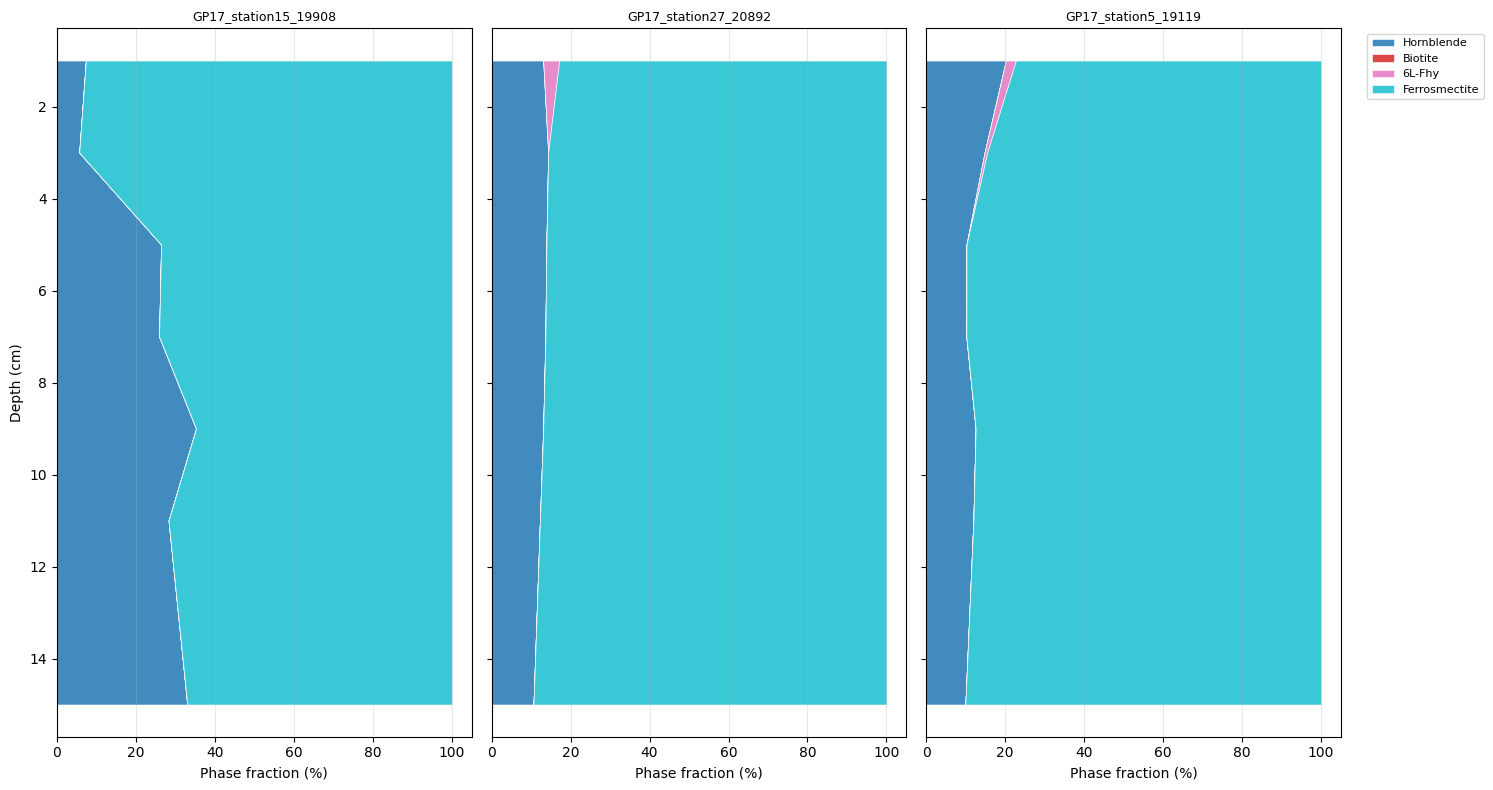

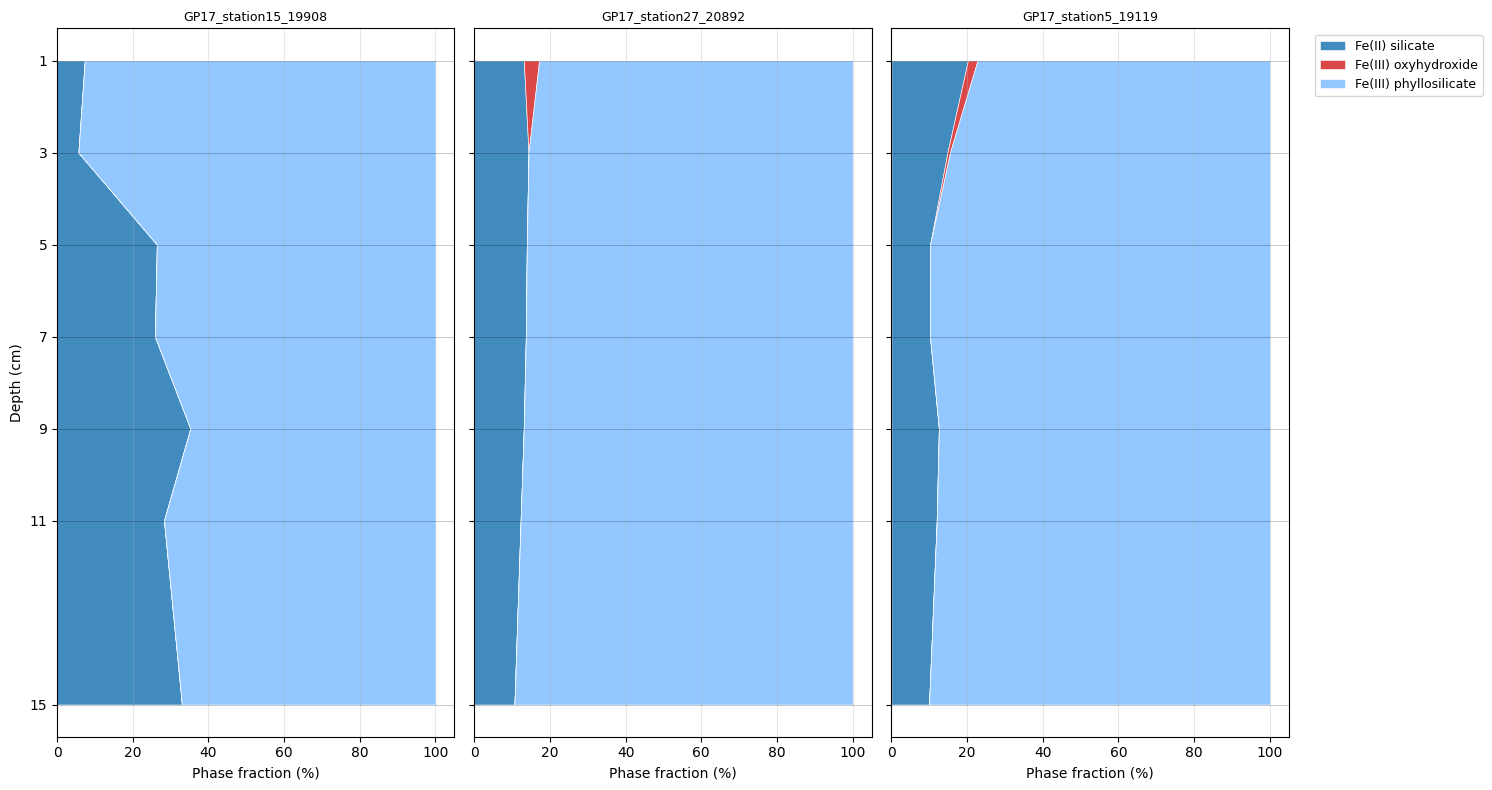

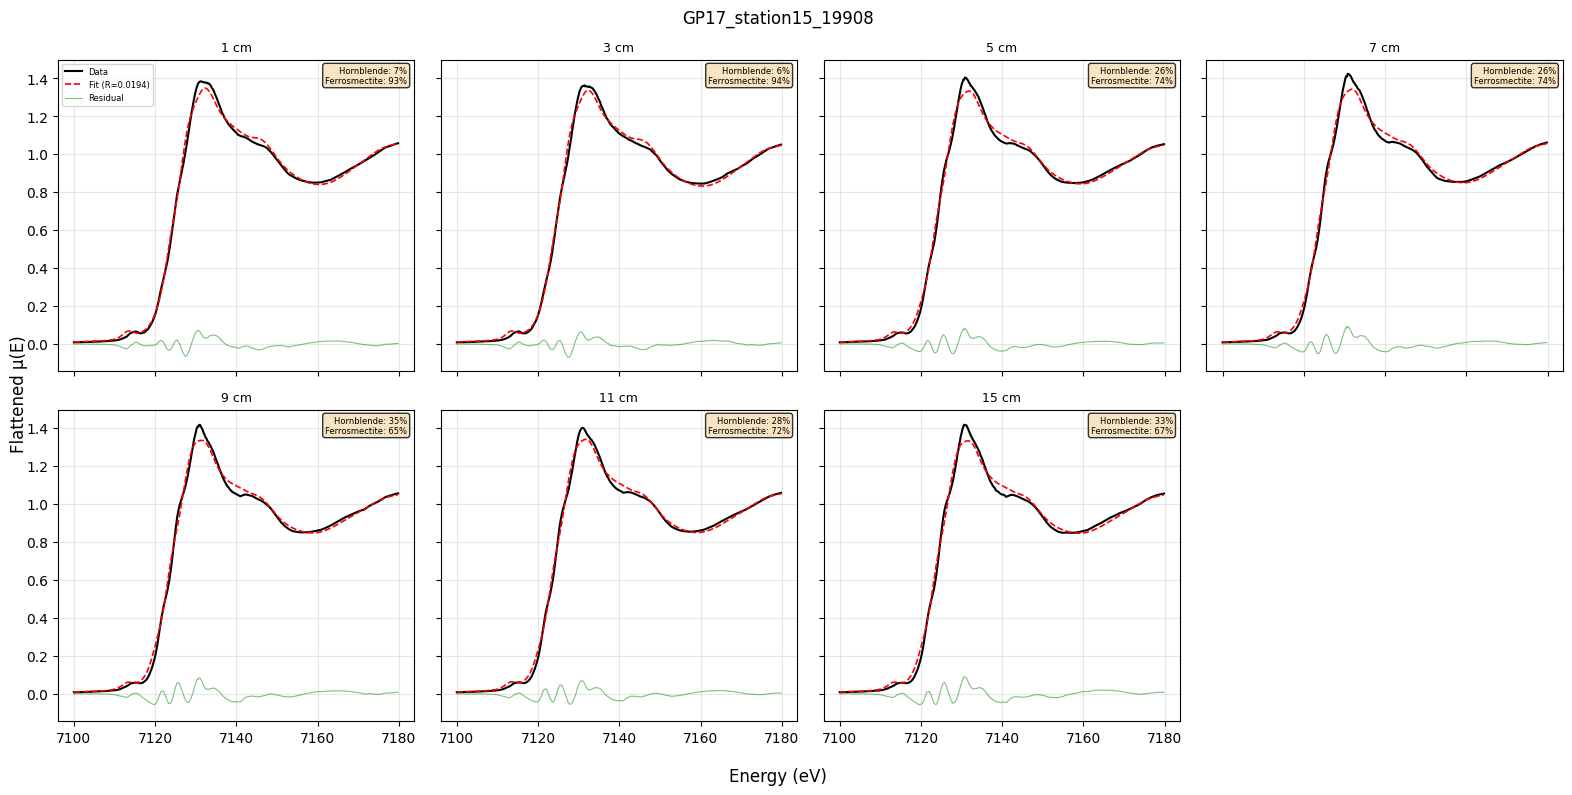

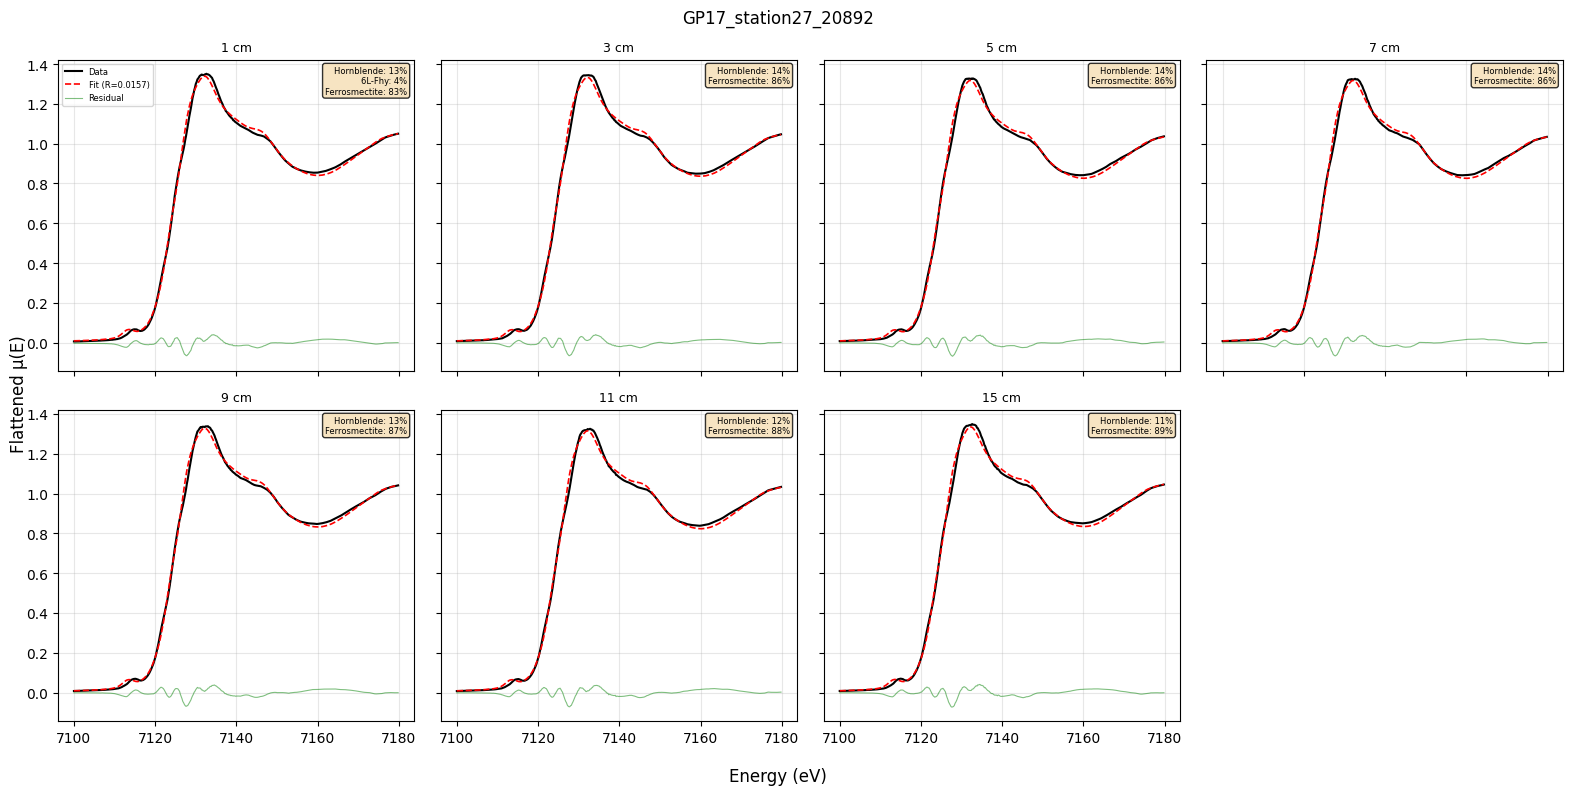

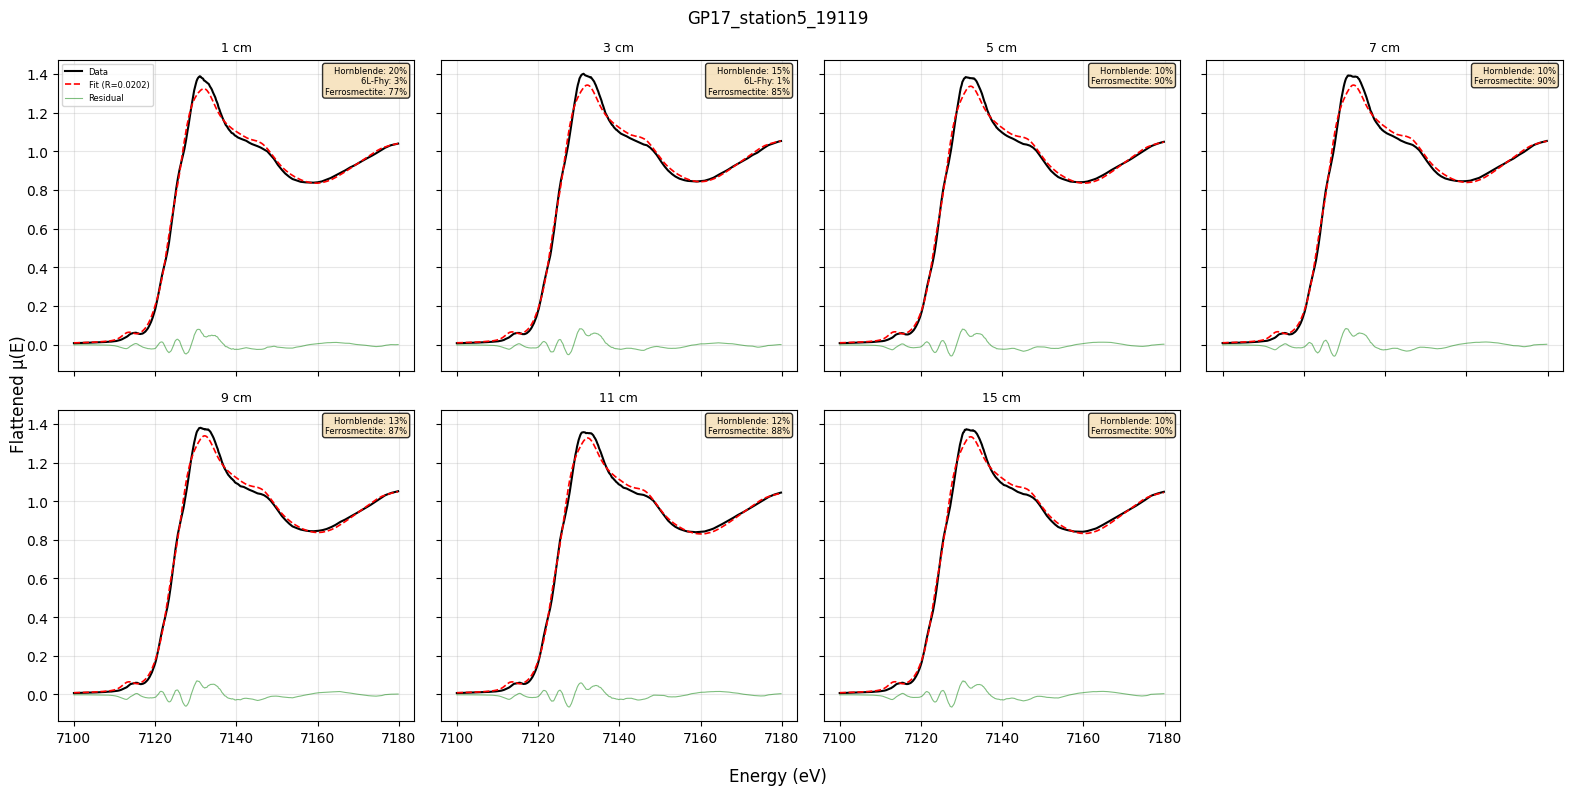

In [7]:
# LCF of bulk spectra using mineral references informed by PCA results
#
# The PCA/clustering identified these dominant phases:
#   - Hornblende, Augite, Biotite (silicates)
#   - 6L-Fhy, Ferrosmectite (Fe(III) phases)
#   - Mackinawite, Mackinawite (aged), Pyrrhotite (sulfides)
#   - Siderite-s, Siderite-n (carbonates)
#   - Ilmenite (heavy mineral)
#   - Vivianite (phosphate)
#
# Adjust this list based on your interpretation of the PCA results.

# ============================================================
# CONFIGURATION
# ============================================================

# References to use for bulk LCF — selected from PCA/clustering results
# Group by mineralogical class to avoid redundancy
BULK_REFS = {
    # name: path — pick one representative per spectral type
    "Hornblende":         REFERENCE_DIR / "Hornblende.csv",
    "Biotite":            REFERENCE_DIR / "Biotite.csv",
    "6L-Fhy":             REFERENCE_DIR / "6L-Fhy.csv",
    "Ferrosmectite":      REFERENCE_DIR / "Ferrosmectite.csv",
    "Goethite":           REFERENCE_DIR / "Goethite.csv",
    "Mackinawite (aged)": REFERENCE_DIR / "Mackinawite (aged).csv",
    "Siderite-s":         REFERENCE_DIR / "Siderite-s.csv",
    "Ilmenite":           REFERENCE_DIR / "Ilmenite.csv",
    "Pyrrhotite":         REFERENCE_DIR / "Pyrrhotite.csv",
    "Vivianite":          REFERENCE_DIR / "Vivianite.csv",
}

# Max number of references per fit
BULK_MAX_REFS = 4

BULK_OUTPUT_DIR = BULK_DIR

# Phase grouping for plotting
PHASE_GROUPS = {
    "Fe(III) oxyhydroxide":    ["6L-Fhy", "Goethite"],
    "Fe(III) phyllosilicate":  ["Ferrosmectite"],
    "Fe(II) phyllosilicate":   ["Biotite"],
    "Fe(II) silicate":         ["Hornblende"],
    "Fe sulfide":              ["Mackinawite (aged)", "Pyrrhotite"],
    "Fe(II) carbonate":        ["Siderite-s"],
    "Fe-Ti oxide":             ["Ilmenite"],
    "Fe(II) phosphate":        ["Vivianite"],
}

# Fixed plot order and colors
PLOT_ORDER = [
    "Fe(II) silicate",
   # "Fe(II) phyllosilicate",
    "Fe(III) oxyhydroxide",
    "Fe(III) phyllosilicate",
]

GROUP_COLORS = {
    "Fe(III) oxyhydroxide":    "#d62728",
    "Fe(III) phyllosilicate":  "#7fbfff",
    "Fe(II) phyllosilicate":   "#aec7e8",
    "Fe(II) silicate":         "#1f77b4",
    "Fe sulfide":              "#2ca02c",
    "Fe(II) carbonate":        "#ff7f0e",
    "Fe-Ti oxide":             "#9467bd",
    "Fe(II) phosphate":        "#8c564b",
}
# ============================================================
# FIT
# ============================================================

import re

def parse_bulk_filename(filename):
    """
    Extract station and depth from filename.
    Example: GP17_station5_19119_1cm_015_A_fl.avg -> station='GP17_station5_19119', depth=1.0
    """
    stem = Path(filename).stem
    depth_match = re.search(r'(\d+\.?\d*)cm', stem)
    if not depth_match:
        return None, None
    depth = float(depth_match.group(1))
    station = stem[:depth_match.start()].rstrip('_')
    return station, depth

    
def lcf_bulk_with_references(x_grid, bulk_dir, bulk_refs, max_refs=4, pattern="*.csv"):
    """
    Fit each bulk spectrum as a linear combination of mineral references.
    Tests all combinations of 1 to max_refs and picks the best fit.
    """
    from scipy.optimize import nnls
    from itertools import combinations

    # Load and interpolate references
    ref_names = list(bulk_refs.keys())
    ref_spectra = {}
    for name, path in bulk_refs.items():
        try:
            dat = np.loadtxt(str(path), delimiter=",", comments="#")
            ref_spectra[name] = np.interp(x_grid, dat[:, 0], dat[:, 1])
        except Exception as e:
            print(f"  Skipping {name}: {e}")
    
    ref_names = list(ref_spectra.keys())
    ref_matrix = np.array([ref_spectra[n] for n in ref_names])
    
    # Precompute combos
    all_combos = []
    for n in range(1, max_refs + 1):
        for combo in combinations(range(len(ref_names)), n):
            all_combos.append(combo)
    print(f"Using {len(ref_names)} references, testing {len(all_combos)} combinations per spectrum")

    # Load and fit bulk spectra
    bulk_files = sorted(Path(bulk_dir).glob(pattern))
    print(f"Found {len(bulk_files)} bulk spectra")

    results = []
    for bf in bulk_files:
        station, depth = parse_bulk_filename(bf.name)
        if station is None:
            print(f"  Skipping {bf.name}: could not parse depth")
            continue

        try:
            dat = np.loadtxt(str(bf), delimiter=",", comments="#")
            bulk_interp = np.interp(x_grid, dat[:, 0], dat[:, 1])

            best = {"r_factor": np.inf}
            for combo in all_combos:
                A = ref_matrix[list(combo)].T
                weights, _ = nnls(A, bulk_interp)
                fitted = A @ weights
                residual = bulk_interp - fitted
                r_factor = np.sum(np.abs(residual)) / np.sum(np.abs(bulk_interp))

                if r_factor < best["r_factor"]:
                    best = {
                        "refs": [ref_names[i] for i in combo],
                        "weights": weights,
                        "r_factor": r_factor,
                        "chi_sq": np.sum(residual ** 2) / len(residual),
                        "weight_sum": np.sum(weights),
                        "fitted": fitted,
                    }

            row = {
                "filename": bf.name,
                "station": station,
                "depth_cm": depth,
                "r_factor": best["r_factor"],
                "chi_sq": best["chi_sq"],
                "weight_sum": best["weight_sum"],
                "n_refs": len(best["refs"]),
                "components": ", ".join(best["refs"]),
            }
            for rn, w in zip(best["refs"], best["weights"]):
                row[rn] = w / best["weight_sum"] if best["weight_sum"] > 0 else 0
            results.append(row)

        except Exception as e:
            print(f"  Error fitting {bf.name}: {e}")

    df = pd.DataFrame(results).fillna(0).sort_values(["station", "depth_cm"])
    print(f"Fit {len(df)} spectra across {df['station'].nunique()} stations")
    return df


# ============================================================
# PHASE GROUPING
# ============================================================

def aggregate_phases(df, phase_groups):
    """Sum individual mineral fractions into geochemical classes."""
    meta_cols = ["filename", "station", "depth_cm", "r_factor", "chi_sq", "weight_sum", "n_refs", "components"]
    df_grouped = df[[c for c in meta_cols if c in df.columns]].copy()
    for group_name, members in phase_groups.items():
        cols = [c for c in members if c in df.columns]
        df_grouped[group_name] = df[cols].sum(axis=1)
    return df_grouped


# ============================================================
# PLOTTING
# ============================================================

def plot_bulk_depth_profiles(df, bulk_refs, output_dir):
    """Stacked area depth profiles using mineral reference fractions."""
    ref_names = list(bulk_refs.keys())
    phase_cols = [c for c in ref_names if c in df.columns]
    stations = sorted(df["station"].unique())
    n_stations = len(stations)

    colors = plt.cm.tab10(np.linspace(0, 1, len(phase_cols)))

    fig, axes = plt.subplots(1, n_stations, figsize=(5 * n_stations, 8), sharey=True)
    if n_stations == 1:
        axes = [axes]

    for ax, station in zip(axes, stations):
        sdf = df[df["station"] == station].sort_values("depth_cm")
        depths = sdf["depth_cm"].values

        cumulative = np.zeros(len(depths))
        for col, color in zip(phase_cols, colors):
            values = sdf[col].values * 100 if col in sdf.columns else np.zeros(len(depths))
            ax.fill_betweenx(depths, cumulative, cumulative + values,
                             color=color, label=col, alpha=0.85,
                             edgecolor="white", linewidth=0.5)
            cumulative += values

        ax.set_xlabel("Phase fraction (%)")
        ax.set_title(station, fontsize=9)
        ax.invert_yaxis()
        ax.set_xlim(0, 105)
        ax.grid(True, alpha=0.3, axis="x")

    axes[0].set_ylabel("Depth (cm)")
    handles, labels = axes[0].get_legend_handles_labels()
    axes[-1].legend(handles, labels, bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
    plt.tight_layout()
    plt.savefig(output_dir / "bulk_depth_profiles.png", dpi=150, bbox_inches="tight")
    plt.show()


def plot_grouped_depth_profiles(df, phase_groups, group_colors, output_dir, 
                                plot_order=None, n_top=3):
    """Stacked area depth profiles using grouped phase fractions."""
    phase_cols = [g for g in phase_groups.keys() if g in df.columns]
    stations = sorted(df["station"].unique())
    n_stations = len(stations)

    # Use fixed order if provided, otherwise rank by abundance
    if plot_order:
        top_phases = [p for p in plot_order if p in phase_cols]
    else:
        mean_abundance = {col: df[col].mean() for col in phase_cols}
        top_phases = sorted(mean_abundance, key=mean_abundance.get, reverse=True)[:n_top]
    
    other_phases = [c for c in phase_cols if c not in top_phases]

    fig, axes = plt.subplots(1, n_stations, figsize=(5 * n_stations, 8), sharey=True)
    if n_stations == 1:
        axes = [axes]

    for ax, station in zip(axes, stations):
        sdf = df[df["station"] == station].sort_values("depth_cm")
        depths = sdf["depth_cm"].values

        cumulative = np.zeros(len(depths))
        for col in top_phases:
            values = sdf[col].values * 100
            color = group_colors.get(col, "gray")
            ax.fill_betweenx(depths, cumulative, cumulative + values,
                             color=color, label=col, alpha=0.85,
                             edgecolor="white", linewidth=0.5)
            cumulative += values

        # Lump remaining phases as "Other"
        other_values = sdf[other_phases].sum(axis=1).values * 100
        if other_values.sum() > 0:
            ax.fill_betweenx(depths, cumulative, cumulative + other_values,
                             color="lightgray", label="Other", alpha=0.7,
                             edgecolor="white", linewidth=0.5)

        # Mark actual sample depths
        for d in depths:
            ax.axhline(d, color="black", linewidth=0.5, linestyle="-", alpha=0.3)
        ax.set_yticks(depths)

        ax.set_xlabel("Phase fraction (%)")
        ax.set_title(station, fontsize=9)
        ax.invert_yaxis()
        ax.set_xlim(0, 105)
        ax.grid(True, alpha=0.3, axis="x")

    axes[0].set_ylabel("Depth (cm)")
    handles, labels = axes[0].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    axes[-1].legend(by_label.values(), by_label.keys(),
                    bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9)
    plt.tight_layout()
    plt.savefig(output_dir / "bulk_depth_profiles_grouped.png", dpi=150, bbox_inches="tight")
    plt.show()


def plot_bulk_fits(x_grid, bulk_dir, bulk_refs, df, output_dir, pattern="*.csv"):
    """Plot individual LCF fits for each bulk spectrum."""
    ref_spectra = {}
    for name, path in bulk_refs.items():
        try:
            dat = np.loadtxt(str(path), delimiter=",", comments="#")
            ref_spectra[name] = np.interp(x_grid, dat[:, 0], dat[:, 1])
        except:
            pass

    stations = sorted(df["station"].unique())
    for station in stations:
        sdf = df[df["station"] == station].sort_values("depth_cm")
        n_spectra = len(sdf)
        ncols = min(4, n_spectra)
        nrows = int(np.ceil(n_spectra / ncols))

        fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows), sharex=True, sharey=True)
        axes = np.atleast_2d(axes)

        for idx, (_, row) in enumerate(sdf.iterrows()):
            ax = axes[idx // ncols, idx % ncols]

            # Load bulk spectrum
            bf = Path(bulk_dir) / row["filename"]
            dat = np.loadtxt(str(bf), delimiter=",", comments="#")
            bulk_interp = np.interp(x_grid, dat[:, 0], dat[:, 1])

            # Reconstruct fit
            components = row["components"].split(", ")
            fitted = np.zeros_like(x_grid)
            for ref_name in components:
                if ref_name in ref_spectra and ref_name in row.index:
                    w = row[ref_name] * row["weight_sum"]
                    fitted += w * ref_spectra[ref_name]

            ax.plot(x_grid, bulk_interp, "k-", linewidth=1.5, label="Data")
            ax.plot(x_grid, fitted, "r--", linewidth=1.2, label=f"Fit (R={row['r_factor']:.4f})")
            ax.plot(x_grid, bulk_interp - fitted, "g-", alpha=0.5, linewidth=0.8, label="Residual")

            # Component annotation
            comp_text = "\n".join(
                f"{c}: {row[c]*100:.0f}%" for c in components if c in row.index and row[c] > 0
            )
            ax.text(0.98, 0.98, comp_text, transform=ax.transAxes, fontsize=6,
                    va="top", ha="right", bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8))

            ax.set_title(f"{row['depth_cm']:.0f} cm", fontsize=9)
            ax.grid(True, alpha=0.3)
            if idx == 0:
                ax.legend(fontsize=6)

        # Hide empty subplots
        for idx in range(n_spectra, nrows * ncols):
            axes[idx // ncols, idx % ncols].set_visible(False)

        fig.suptitle(station, fontsize=12)
        fig.supxlabel("Energy (eV)")
        fig.supylabel("Flattened μ(E)")
        plt.tight_layout()
        plt.savefig(output_dir / f"bulk_fits_{station}.png", dpi=150, bbox_inches="tight")
        plt.show()


# ============================================================
# RUN
# ============================================================

bulk_ref_df = lcf_bulk_with_references(x_grid, BULK_DIR, BULK_REFS,
                                        max_refs=BULK_MAX_REFS, pattern=BULK_PATTERN)

# Save mineral-level results
bulk_ref_df.to_csv(BULK_OUTPUT_DIR / "bulk_lcf_mineral_refs.csv", index=False, float_format="%.4f")
print(f"\nSaved: {BULK_OUTPUT_DIR / 'bulk_lcf_mineral_refs.csv'}")

# Print table
print(f"\n{'='*80}")
ref_cols = [c for c in BULK_REFS.keys() if c in bulk_ref_df.columns]
for station in sorted(bulk_ref_df["station"].unique()):
    sdf = bulk_ref_df[bulk_ref_df["station"] == station].sort_values("depth_cm")
    print(f"\n{station}:")
    print(f"  {'Depth':>6s} {'R':>7s} {'Sum':>5s}  Components")
    print(f"  " + "-" * 70)
    for _, row in sdf.iterrows():
        comps = []
        for c in ref_cols:
            if row.get(c, 0) > 0.01:
                comps.append(f"{c} {row[c]*100:.0f}%")
        print(f"  {row['depth_cm']:>5.0f}  {row['r_factor']:>.4f} {row['weight_sum']:>5.2f}  {', '.join(comps)}")

# Aggregate into geochemical classes
bulk_grouped = aggregate_phases(bulk_ref_df, PHASE_GROUPS)
bulk_grouped.to_csv(BULK_OUTPUT_DIR / "bulk_lcf_grouped.csv", index=False, float_format="%.4f")
print(f"\nSaved: {BULK_OUTPUT_DIR / 'bulk_lcf_grouped.csv'}")

# Plots — mineral-level
plot_bulk_depth_profiles(bulk_ref_df, BULK_REFS, BULK_OUTPUT_DIR)

# Plots — grouped by geochemical class
plot_grouped_depth_profiles(bulk_grouped, PHASE_GROUPS, GROUP_COLORS, BULK_OUTPUT_DIR,
                            plot_order=PLOT_ORDER)
# Individual fit plots
plot_bulk_fits(x_grid, BULK_DIR, BULK_REFS, bulk_ref_df, BULK_OUTPUT_DIR, pattern=BULK_PATTERN)